# Clean file with modules

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import inverse_mapping_functions as imf
import Siamese_Architecture as SA

import umap.umap_ as umap


BATCH_SIZE = 64

In [3]:
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc"
datasetdouble = SproutDataset(dataset_path=dataset_path, augmentation_type='double')
dataloader = DataLoader(
            datasetdouble,
            batch_size=BATCH_SIZE,
            shuffle=True)

In [3]:
# checkpoint = "C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\Individual project\SPICE_DeepLearning\\SimSiam_miniDataset_Training_64_Contrastive\kyu6raoh\checkpoints\epoch=2-step=10980.ckpt"
# model = SA.SimSiam.load_from_checkpoint(checkpoint)  # Continue epoch 3

model = SA.SimSiam(output_dim=128, backbone_output_dim=128, hidden_layer_dim=128)

dataset = datasetdouble

wandb_logger = WandbLogger(project="FullDataset_Training_128_doubleAug", log_model=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator=accelerator, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tava8993 (tava8993-boulder). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 924 K  | train
1 | projection_head | SimSiamProjectionHead | 49.7 K | train
2 | prediction_head | SimSiamPredictionHead | 33.2 K | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.028     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 0:  51%|█████     | 9288/18300 [19:14<18:40,  8.04it/s, v_num=mwiu]

In [3]:
checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Fall 2024\ASEN 6337\Individual project\SPICE_DeepLearning\FullDataset_Training_128_doubleAug\\6rr6mwiu\checkpoints\epoch=7-step=146400.ckpt"
dataset_none = SproutDataset(dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc", augmentation_type=None)
outputs = SA.run_model(checkpoint, dataset_none)

100%|██████████| 1171200/1171200 [39:13<00:00, 497.57it/s] 


In [4]:
stacked_outputs = np.stack(outputs).squeeze()
stacked_outputs.shape

(1171200, 128)

In [5]:
embedding_L2 = stacked_outputs / np.linalg.norm(stacked_outputs, ord=2)
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=15, metric='euclidean')
clusterer.fit(embedding_L2)
labels = clusterer.labels_

((array([2.42971e+05, 7.60000e+01, 1.14000e+02, 4.50000e+01, 4.80000e+01,
         7.00000e+01, 4.20000e+01, 5.40000e+01, 3.40000e+01, 9.27746e+05]),
  array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  <BarContainer object of 10 artists>),
 None)

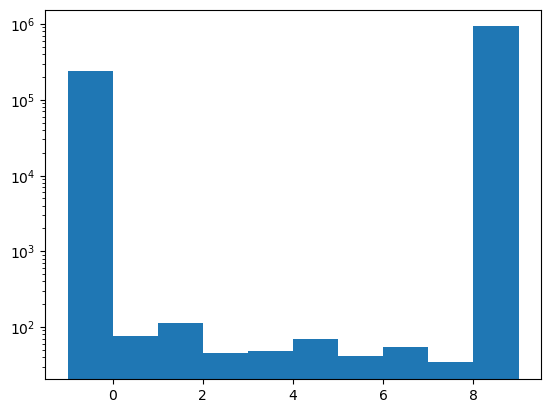

In [6]:
plt.hist(labels), plt.yscale('log')

In [8]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
projected_data = reducer.fit_transform(stacked_outputs)

In [ ]:
# np.save('saved_outputs//umap_data_128_fulldata.npy', projected_data)
# np.save('saved_outputs//stacked_outputs_128_fulldata.npy', stacked_outputs)
# np.save('saved_outputs//clustered_outputs_128_fulldata_minclus30_minsamp15.npy', labels)

In [6]:
projected_data = np.load('saved_outputs//umap_data_128_fulldata.npy')
stacked_outputs = np.load('saved_outputs//stacked_outputs_128_fulldata.npy')
labels = np.load('saved_outputs//clustered_outputs_128_fulldata_minclus30_minsamp15.npy')

In [5]:
from matplotlib.colors import Normalize

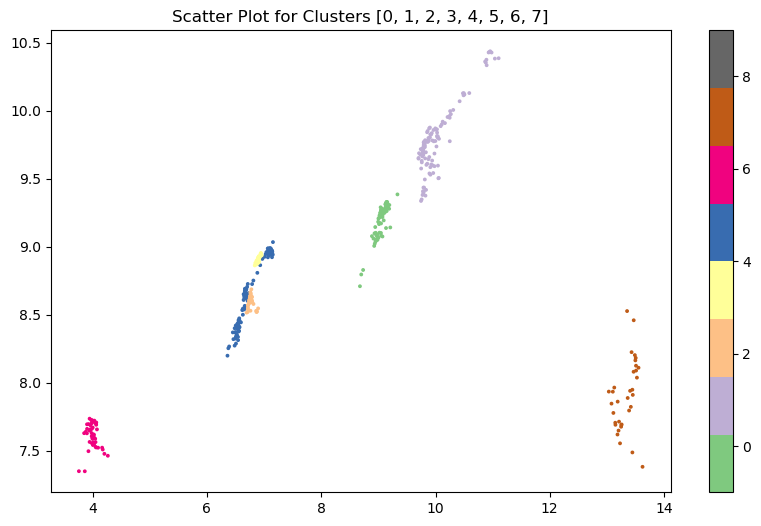

In [74]:
target_clusters = [0, 1, 2, 3, 4, 5, 6, 7]  # List of cluster labels to plot
selected_points = projected_data[np.isin(labels, target_clusters)]
selected_labels = labels[np.isin(labels, target_clusters)]
norm = Normalize(vmin=-1, vmax=9)

plt.figure(figsize=(10, 6))
plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='Accent', norm=norm, s=3)
plt.title(f"Scatter Plot for Clusters {target_clusters}")
plt.colorbar()
plt.show()

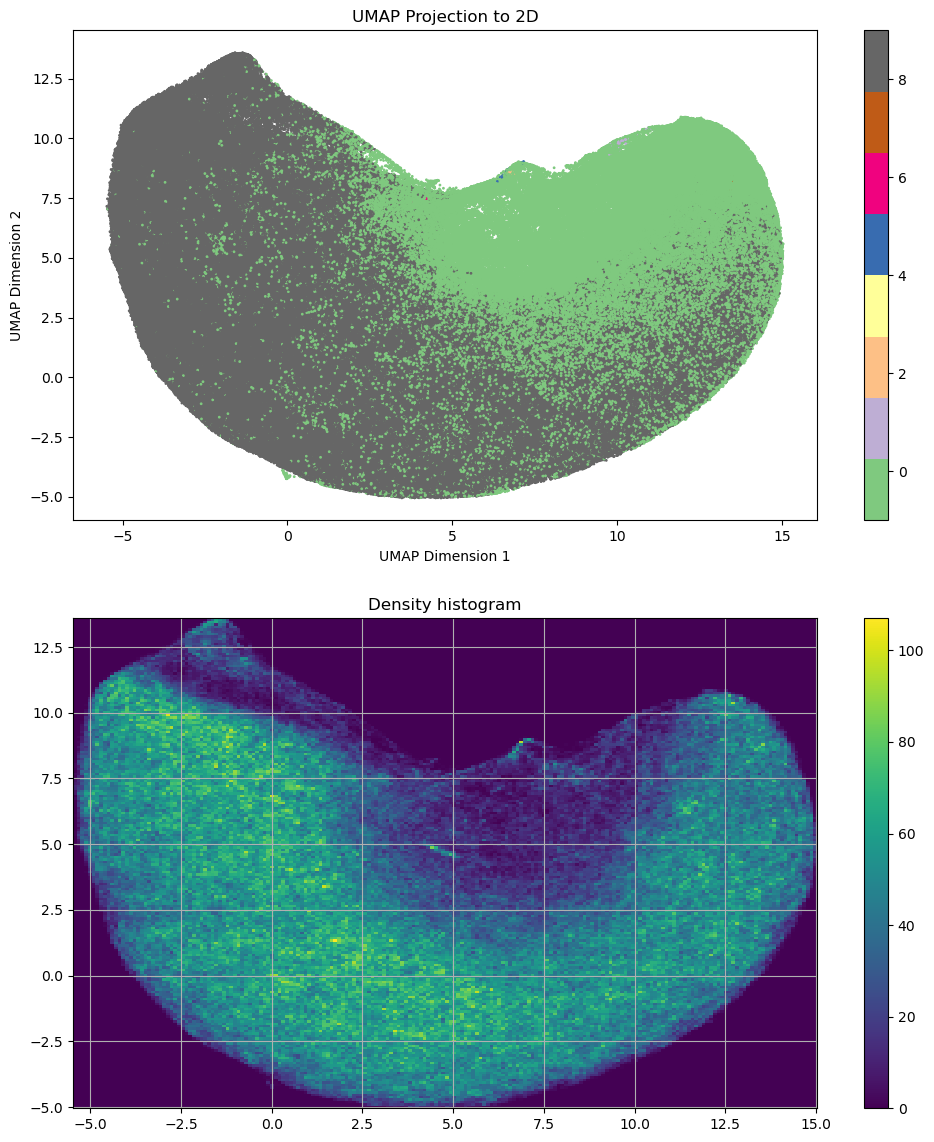

In [68]:
plt.figure(figsize=(12, 14))
plt.subplot(211)
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='Accent', s=1)
plt.colorbar()
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(212)
plt.hist2d(projected_data[:, 0], projected_data[:, 1], bins=200)
plt.colorbar()
plt.grid(True)
plt.title('Density histogram')
plt.show()

10


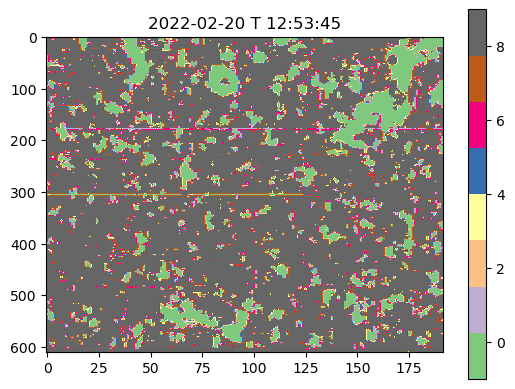

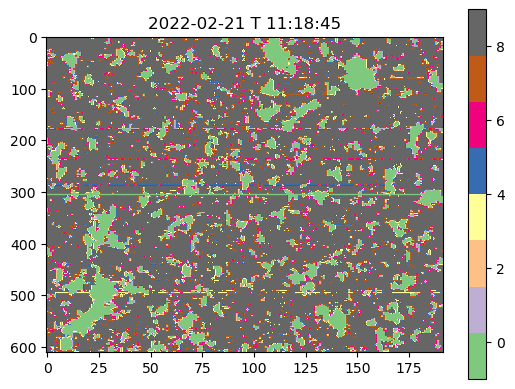

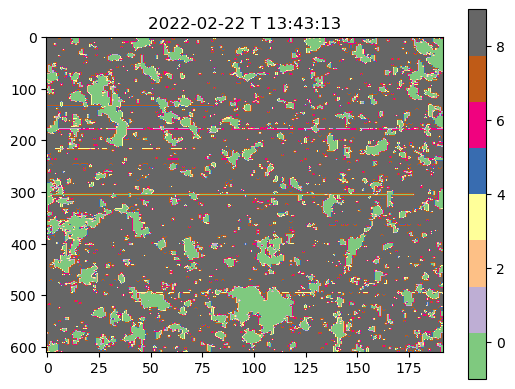

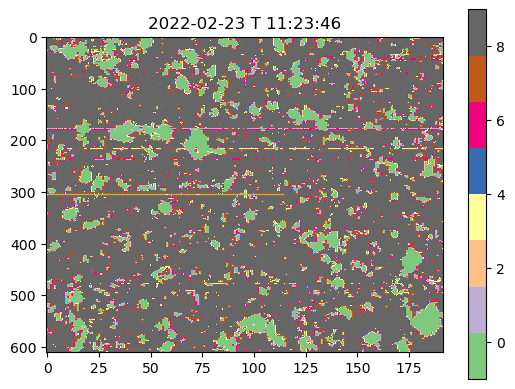

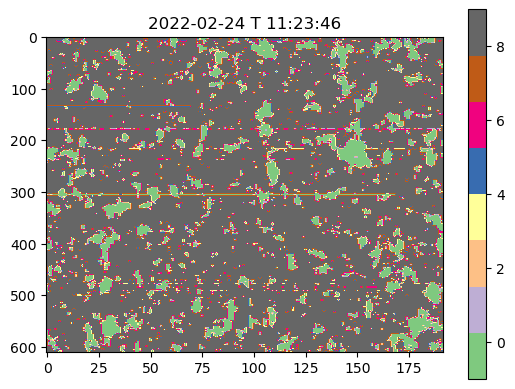

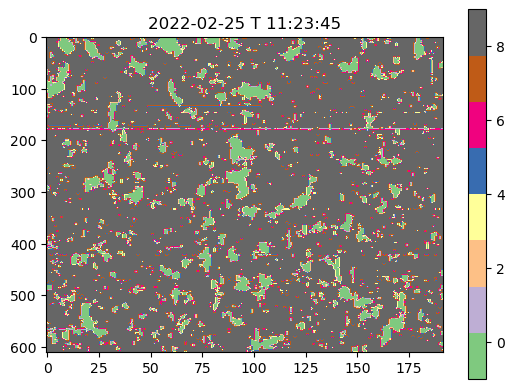

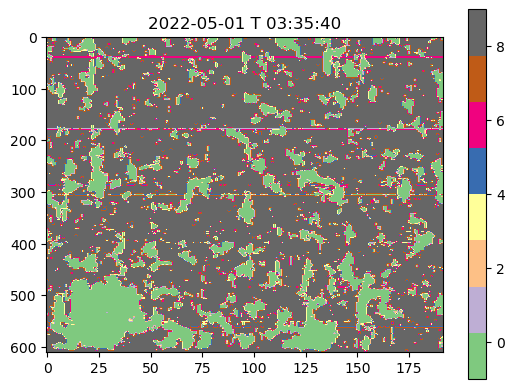

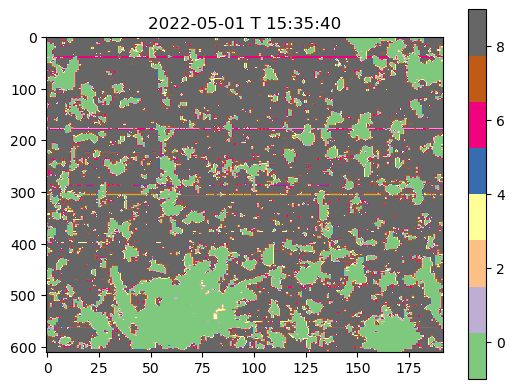

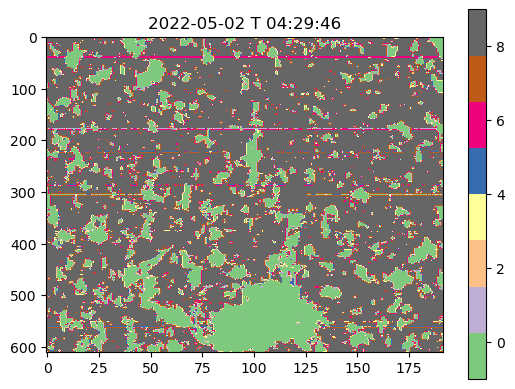

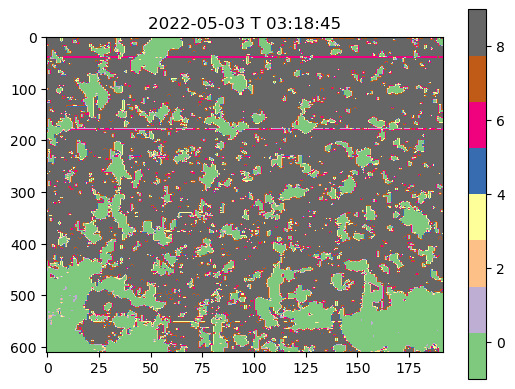

In [9]:
imf.map_clusters(labels, selected_clusters = None)

solo_L2_spice-n-ras_20220501T153540_V22_117440780-000.fits
(40, 610, 192)


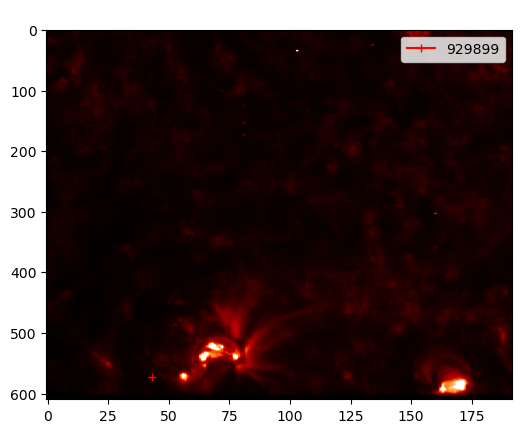

In [7]:
imf.map_item_map(item_nbr=929899, dataset="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc", plot=True, title=' ')

In [10]:
imf.plot_n_random_spectra_cluster(labels, stacked_outputs, 1, dataset, nbr_items=3, plot_on_map=True,
                                  dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc")

NameError: name 'dataset' is not defined